In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/dataset/validation/dogs/dog.9079.jpg
/kaggle/input/dogs-vs-cats/dataset/validation/dogs/dog.3287.jpg
/kaggle/input/dogs-vs-cats/dataset/validation/dogs/dog.222.jpg
/kaggle/input/dogs-vs-cats/dataset/validation/dogs/dog.12325.jpg
/kaggle/input/dogs-vs-cats/dataset/validation/dogs/dog.7717.jpg
/kaggle/input/dogs-vs-cats/dataset/validation/dogs/dog.2875.jpg
/kaggle/input/dogs-vs-cats/dataset/validation/dogs/dog.8644.jpg
/kaggle/input/dogs-vs-cats/dataset/validation/dogs/dog.8190.jpg
/kaggle/input/dogs-vs-cats/dataset/validation/dogs/dog.7804.jpg
/kaggle/input/dogs-vs-cats/dataset/validation/dogs/dog.12035.jpg
/kaggle/input/dogs-vs-cats/dataset/validation/dogs/dog.7153.jpg
/kaggle/input/dogs-vs-cats/dataset/validation/dogs/dog.2888.jpg
/kaggle/input/dogs-vs-cats/dataset/validation/dogs/dog.7275.jpg
/kaggle/input/dogs-vs-cats/dataset/validation/dogs/dog.3108.jpg
/kaggle/input/dogs-vs-cats/dataset/validation/dogs/dog.8388.jpg
/kaggle/input/dogs-vs-cats/dataset/vali

# Introduction

This notebook demonstrates how to build and train a deep learning model from scratch for the task of binary image classification using the Cats vs. Dogs dataset. The primary goal is to develop a convolutional neural network (CNN) that can accurately distinguish between images of cats and dogs.

Image classification is a foundational problem in computer vision with wide-ranging applications from autonomous driving to medical diagnostics. The Cats vs. Dogs dataset offers a perfect balance between simplicity and complexity: while the task of differentiating cats from dogs is intuitive, the dataset’s size and variability demand a sufficiently large and capable model. This makes it an ideal benchmark for developing, optimizing, and evaluating deep learning architectures.

This notebook is the first in a planned series of notebooks that together cover the full lifecycle of building efficient deep learning models. Future notebooks will explore:
- **Model pruning** to reduce model size and computational requirements without significant loss in accuracy.  
- **Knowledge distillation** to transfer learned knowledge from this larger “teacher” model to a smaller, more efficient “student” model.  
- **Quantization** to optimize the model for deployment on resource-constrained devices.  
- **Deployment** strategies for practical use cases.

The CNN architecture implemented here is designed to be both interpretable and sufficiently complex, serving as an ideal foundation for the optimization techniques discussed in the subsequent notebooks.

---


The Cats vs. Dogs dataset consists of three subsets:

- **Training set:** 20,000 images (10,000 cats and 10,000 dogs) with diverse poses, backgrounds, and lighting conditions.  
- **Validation set:** 5,000 images (2,500 cats and 2,500 dogs) used for hyperparameter tuning and intermediate evaluation.  
- **Test set:** 12,461 images (6,242 cats and 6,219 dogs) reserved for final evaluation on unseen data.

All images will be preprocessed by resizing and normalization to ensure consistency and stable training.

# Setup and Imports

In this section, we import the necessary libraries and configure the runtime environment. This includes setting random seeds for reproducibility and selecting the appropriate device (CPU or GPU) for model training.

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import tqdm
from collections import OrderedDict
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from torchinfo import summary

# pytorch essientials
import torch
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Enviornment configuration
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Device
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Data Preprocessing and Loading

In this section, we prepare the dataset for training. This includes:

- Defining image transformations such as resizing, normalization, and data augmentation
- Loading the dataset using `ImageFolder`
- Creating DataLoaders for training, validation, and test sets

---

In [3]:
train_folder = "/kaggle/input/dogs-vs-cats/dataset/train"
val_folder = "/kaggle/input/dogs-vs-cats/dataset/validation"
test_folder = "/kaggle/input/dogs-vs-cats/dataset/test"

## Compute Dataset Mean and Standard Deviation

To normalize the dataset properly, we compute the channel-wise mean and standard deviation of the training set. This ensures the input distribution is centered and scaled, which stabilizes and speeds up training.

---

In [4]:
image_size = 128
batch_size = 128

In [5]:
temp_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

temp_dataset = datasets.ImageFolder(root=train_folder, transform=temp_transforms)
print(f"Classes: {temp_dataset.find_classes(train_folder)[1]}")
temp_dataloader = DataLoader(dataset=temp_dataset, batch_size=batch_size)
print(type(temp_dataloader))

Classes: {'cats': 0, 'dogs': 1}
<class 'torch.utils.data.dataloader.DataLoader'>


In [6]:
def compute_mean_std(loader):
    n_images = 0 # the last batch might not be full we keep track of the number images
    mean = 0.
    std = 0.

    for images, _ in tqdm.tqdm(loader):
        batch_sample = images.size(0)
        images = images.view(batch_sample, images.size(1), -1) # this convers to(B, C, H*W)

        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        n_images += batch_sample

    mean = mean/n_images
    std = std/n_images
    return mean, std

In [7]:
mean, std = compute_mean_std(temp_dataloader)
print(f"mean: {mean.tolist()}, std: {std.tolist()}")

100%|██████████| 157/157 [01:44<00:00,  1.50it/s]

mean: [0.48825347423553467, 0.45504486560821533, 0.4168395400047302], std: [0.2225690633058548, 0.21782387793064117, 0.218031108379364]


# Data Preprocessing and Loading

In this section, we prepare the dataset for training. This includes:

- Defining image transformations such as resizing, normalization, and data augmentation
- Loading the dataset using `ImageFolder`
- Creating DataLoaders for training, validation, and test sets

---

In [8]:
transform_train = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomAffine(degrees=20, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.RandomAutocontrast(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist()),
])

transform_val = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist()),
])

In [9]:
train_dataset = datasets.ImageFolder(root=train_folder, transform=transform_train)
val_dataset = datasets.ImageFolder(root=val_folder, transform=transform_val)
test_dataset = datasets.ImageFolder(root=test_folder, transform=transform_val)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size)

In [10]:
class_names = train_dataset.classes
print(class_names)

['cats', 'dogs']


## Visualize Sample Images

Before training, it's helpful to visualize some samples from the training set to verify image shapes, class balance, and augmentation effects.

---

In [11]:
def imshow(inp, ax, title=None):
    # Unnormalize
    if isinstance(mean, torch.Tensor):
        mean_tensor = mean.view(3, 1, 1)
        std_tensor = std.view(3, 1, 1)
    else:
        mean_tensor = torch.tensor(mean).view(3, 1, 1)
        std_tensor = torch.tensor(std).view(3, 1, 1)

    inp = inp.cpu() * std_tensor + mean_tensor  # unnormalize
    inp = inp.numpy().transpose((1, 2, 0))  # C x H x W → H x W x C
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)
    if title is not None:
        ax.set_title(title)
    ax.axis('off')

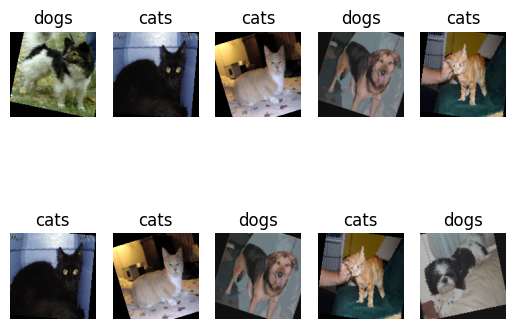

In [12]:
image = iter(train_dataloader)
image, label = next(image)
fig, axs = plt.subplots(2, 5)
for i in range(2):
    for j in range(5):
        imshow(image[i+j], axs[i, j],class_names[label[i+j]])

## Model Architecture

In this section, we define a custom Convolutional Neural Network (CNN) from scratch to solve the binary image classification task of distinguishing between cats and dogs.

This model is intentionally designed with enough depth and parameter complexity to make it a suitable candidate for future optimization techniques such as:
- **Pruning**
- **Knowledge Distillation**
- **Quantization**

These techniques will be explored in later notebooks as part of this project series.

---

### Why This Architecture?

The goal is to strike a balance between:
- **Simplicity** — so that the architecture is understandable and easy to analyze.
- **Complexity** — enough parameters and layers to allow for non-trivial learning and optimizations.

This CNN architecture contains:
- Multiple **convolutional layers** to extract features
- **Batch normalization** to stabilize and speed up training
- **ReLU activations** to introduce non-linearity
- **Max pooling layers** to reduce spatial dimensions
- **Dropout** for regularization
- **Fully connected layers** that map extracted features to a final binary classification output using a **sigmoid activation**

---

In [13]:
conv1_layer = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Dropout2d(0.2),
)

conv2_layer = nn.Sequential(
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Dropout2d(0.2),
)

conv3_layer = nn.Sequential(
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Dropout2d(0.2),
    nn.MaxPool2d(kernel_size=3),
)

conv4_layer = nn.Sequential(
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Dropout2d(0.2),
    nn.MaxPool2d(kernel_size=3)
)

fully_connected = nn.Sequential(
    nn.Flatten(),
    nn.Linear(14*14*128, 1024),
    nn.BatchNorm1d(1024),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.BatchNorm1d(512),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(512, 128),
    nn.BatchNorm1d(128),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(128, 32),
    nn.BatchNorm1d(32),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(32, 1),
    nn.Sigmoid()
)

model = nn.Sequential(OrderedDict(
    [
        ('conv1_layer', conv1_layer),
        ('conv2_layer', conv2_layer),
        ('conv3_layer', conv3_layer),
        ('conv4_layer', conv4_layer),
        ('fully_connected', fully_connected)
    ])
)

### 📊 Model Summary

We use `torchinfo` to generate a detailed summary of the model. This provides:

- Total number of layers and parameters
- Trainable vs. non-trainable parameters
- Input and output sizes at each layer

This is particularly helpful when analyzing the effect of pruning, quantization, and distillation in later stages of this project.


In [14]:
summary(model, input_size=(1, 3, image_size, image_size), col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
Sequential                               [1, 3, 128, 128]          [1, 1]                    --                        True
├─Sequential: 1-1                        [1, 3, 128, 128]          [1, 16, 128, 128]         --                        True
│    └─Conv2d: 2-1                       [1, 3, 128, 128]          [1, 16, 128, 128]         448                       True
│    └─BatchNorm2d: 2-2                  [1, 16, 128, 128]         [1, 16, 128, 128]         32                        True
│    └─ReLU: 2-3                         [1, 16, 128, 128]         [1, 16, 128, 128]         --                        --
│    └─Dropout2d: 2-4                    [1, 16, 128, 128]         [1, 16, 128, 128]         --                        --
├─Sequential: 1-2                        [1, 16, 128, 128]         [1, 32, 128, 128]         --                        True
│    └─

## Training Phase

In this section, we define and execute the training loop for our custom convolutional neural network (CNN). The objective is to enable the model to accurately classify images from the `Cats vs. Dogs` dataset.

### Key Components of the Training Loop:

- **Model Architecture:** A deep CNN with four convolutional layers followed by a multi-layer fully connected classifier.
- **Loss Function:** `BCELoss` (Binary Cross-Entropy Loss), ideal for binary classification problems like ours.
- **Optimizer:** `AdamW` is used for its adaptive learning rate and effective weight decay, which helps improve generalization.
- **Learning Rate Scheduler:**  
  A **Cosine Annealing Scheduler** is integrated to adjust the learning rate over epochs. This scheduling strategy reduces the learning rate gradually following a cosine curve, helping the model converge more smoothly and potentially escape local minima in the loss landscape.

  > Cosine annealing can be particularly beneficial when training deep models, especially for tasks where long-term fine-tuning is required.

- **Validation:**  
  At the end of each epoch, the model is evaluated on a separate validation set to:
  - Track performance (loss, accuracy, and custom metrics)
  - Prevent overfitting through early stopping

- **Checkpointing (Optional):**  
  The best model (based on validation loss) is saved during training, enabling recovery and future evaluation.

- **Early Stopping (Optional):**  
  If the validation loss does not improve after a defined number of epochs (`patience`), training is halted early to avoid overfitting.

### What's Next?

This training phase sets the foundation for **model compression and optimization**. The trained model will later serve as a **teacher** in the knowledge distillation process and as a target for **pruning** and **quantization** strategies.

---


In [15]:
def train_network(
    model,
    loss_func,
    train_loader,
    val_loader=None,
    score_funcs=None,
    epochs=50,
    checkpoint_file=None,
    optimizer=None,
    lr_scheduler=None,
    patience=10,
    device="cpu"
):


    if optimizer is None:
        optimizer = torch.optim.AdamW(model.parameters())

    model.to(device)
    print(f"Model operating on: {device}")

    best_val_loss = float("inf")
    num_bad_epochs = 0
    if score_funcs is not None:
        metrics = {name:[] for name in score_funcs}
    metrics["train_loss"] = []
    metrics["val_loss"] = []
    

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        loop = tqdm.tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}] - Training")

        for inputs, labels in loop:
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            optimizer.zero_grad()
            outputs = model(inputs).squeeze(1)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        avg_train_loss = running_loss / len(train_loader)
        metrics["train_loss"].append(avg_train_loss)
        print(f"Epoch {epoch+1} | Training Loss: {avg_train_loss:.4f}")

        # Validation
        if val_loader:
            model.eval()
            val_loss = 0.0
            correct = 0
            total = 0

            with torch.no_grad():
                preds_list = []
                labels_list = []
                for val_inputs, val_labels in val_loader:
                    val_inputs = val_inputs.to(device)
                    val_labels = val_labels.to(device).float()
                    outputs = model(val_inputs).squeeze(1)
                    loss = loss_func(outputs, val_labels)
                    val_loss += loss.item()

                    preds = (outputs > 0.5).float()
                    correct += (preds == val_labels).sum().item()
                    total += val_labels.size(0)

                    preds_list.append(preds.cpu())
                    labels_list.append(val_labels.cpu())

            avg_val_loss = val_loss / len(val_loader)
            metrics["val_loss"].append(avg_val_loss)
            print(f"→ Validation Loss: {avg_val_loss:.4f}")

            # Score functions (optional)
            if score_funcs:
                preds_all = torch.cat(preds_list)
                labels_all = torch.cat(labels_list)
                for name, func in score_funcs.items():
                    metric = func(preds_all, labels_all)
                    metrics[name].append(metric)
                    print(f"→ {name}: {metric:.4f}")
                del preds_all
                del labels_all

            # Early stopping and checkpointing
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                num_bad_epochs = 0
                if checkpoint_file:
                    checkpoint = {'model': model,
                                  'state_dict': model.state_dict(),
                                  'optimizer' : optimizer.state_dict()}

                    torch.save(checkpoint, 'checkpoint.pth')
                    print("Model checkpoint saved.")
            else:
                num_bad_epochs += 1
                print(f"Validation loss did not improve for {num_bad_epochs} epoch(s).")

            if num_bad_epochs >= patience:
                print("Early stopping triggered.")
                break

        # Step LR scheduler
        if lr_scheduler is not None:
            lr_scheduler.step()

    print("Training complete.")
    return metrics


In [16]:
epochs = 200
loss_func = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs//15, eta_min=0.0001)
checkpoint_file = "dummy"


results = train_network(model=model,
                        loss_func=loss_func,
                        train_loader=train_dataloader, 
                        val_loader=val_dataloader,
                        score_funcs = {
                        "accuracy": accuracy_score,
                        "f1_score": f1_score
                        },
                        checkpoint_file= checkpoint_file, 
                        optimizer=optimizer, 
                        lr_scheduler=scheduler, 
                        epochs=epochs, 
                        device = device)

Model operating on: cuda


Epoch [1/200] - Training: 100%|██████████| 157/157 [02:04<00:00,  1.26it/s, loss=0.507]


Epoch 1 | Training Loss: 0.6489
→ Validation Loss: 0.5893
→ accuracy: 0.6928
→ f1_score: 0.6408
Model checkpoint saved.


Epoch [2/200] - Training: 100%|██████████| 157/157 [02:03<00:00,  1.28it/s, loss=0.574]


Epoch 2 | Training Loss: 0.6014
→ Validation Loss: 0.5559
→ accuracy: 0.7128
→ f1_score: 0.7350
Model checkpoint saved.


Epoch [3/200] - Training: 100%|██████████| 157/157 [02:03<00:00,  1.27it/s, loss=0.573]


Epoch 3 | Training Loss: 0.5825
→ Validation Loss: 0.5362
→ accuracy: 0.7292
→ f1_score: 0.6660
Model checkpoint saved.


Epoch [4/200] - Training: 100%|██████████| 157/157 [02:03<00:00,  1.27it/s, loss=0.74]


Epoch 4 | Training Loss: 0.5460
→ Validation Loss: 0.4728
→ accuracy: 0.7842
→ f1_score: 0.7776
Model checkpoint saved.


Epoch [5/200] - Training: 100%|██████████| 157/157 [02:03<00:00,  1.27it/s, loss=0.519]


Epoch 5 | Training Loss: 0.5170
→ Validation Loss: 0.4302
→ accuracy: 0.8010
→ f1_score: 0.7913
Model checkpoint saved.


Epoch [6/200] - Training: 100%|██████████| 157/157 [02:03<00:00,  1.27it/s, loss=0.493]


Epoch 6 | Training Loss: 0.4952
→ Validation Loss: 0.4228
→ accuracy: 0.8006
→ f1_score: 0.8088
Model checkpoint saved.


Epoch [7/200] - Training: 100%|██████████| 157/157 [02:06<00:00,  1.24it/s, loss=0.488]


Epoch 7 | Training Loss: 0.4744
→ Validation Loss: 0.3983
→ accuracy: 0.8222
→ f1_score: 0.8256
Model checkpoint saved.


Epoch [8/200] - Training: 100%|██████████| 157/157 [02:04<00:00,  1.26it/s, loss=0.362]


Epoch 8 | Training Loss: 0.4568
→ Validation Loss: 0.3842
→ accuracy: 0.8280
→ f1_score: 0.8304
Model checkpoint saved.


Epoch [9/200] - Training: 100%|██████████| 157/157 [02:03<00:00,  1.27it/s, loss=0.351]


Epoch 9 | Training Loss: 0.4475
→ Validation Loss: 0.3802
→ accuracy: 0.8286
→ f1_score: 0.8242
Model checkpoint saved.


Epoch [10/200] - Training: 100%|██████████| 157/157 [02:01<00:00,  1.30it/s, loss=0.382]


Epoch 10 | Training Loss: 0.4312
→ Validation Loss: 0.3677
→ accuracy: 0.8370
→ f1_score: 0.8402
Model checkpoint saved.


Epoch [11/200] - Training: 100%|██████████| 157/157 [02:03<00:00,  1.27it/s, loss=0.33]


Epoch 11 | Training Loss: 0.4242
→ Validation Loss: 0.3590
→ accuracy: 0.8386
→ f1_score: 0.8373
Model checkpoint saved.


Epoch [12/200] - Training: 100%|██████████| 157/157 [02:03<00:00,  1.27it/s, loss=0.369]


Epoch 12 | Training Loss: 0.4172
→ Validation Loss: 0.3622
→ accuracy: 0.8400
→ f1_score: 0.8464
Validation loss did not improve for 1 epoch(s).


Epoch [13/200] - Training: 100%|██████████| 157/157 [02:03<00:00,  1.28it/s, loss=0.305]


Epoch 13 | Training Loss: 0.4123
→ Validation Loss: 0.3538
→ accuracy: 0.8464
→ f1_score: 0.8503
Model checkpoint saved.


Epoch [14/200] - Training: 100%|██████████| 157/157 [02:03<00:00,  1.27it/s, loss=0.249]


Epoch 14 | Training Loss: 0.4070
→ Validation Loss: 0.3514
→ accuracy: 0.8496
→ f1_score: 0.8518
Model checkpoint saved.


Epoch [15/200] - Training: 100%|██████████| 157/157 [02:03<00:00,  1.27it/s, loss=0.434]


Epoch 15 | Training Loss: 0.4057
→ Validation Loss: 0.3551
→ accuracy: 0.8478
→ f1_score: 0.8522
Validation loss did not improve for 1 epoch(s).


Epoch [16/200] - Training: 100%|██████████| 157/157 [02:03<00:00,  1.28it/s, loss=0.458]


Epoch 16 | Training Loss: 0.4054
→ Validation Loss: 0.3549
→ accuracy: 0.8442
→ f1_score: 0.8499
Validation loss did not improve for 2 epoch(s).


Epoch [17/200] - Training: 100%|██████████| 157/157 [02:02<00:00,  1.28it/s, loss=0.294]


Epoch 17 | Training Loss: 0.4031
→ Validation Loss: 0.3508
→ accuracy: 0.8514
→ f1_score: 0.8575
Model checkpoint saved.


Epoch [18/200] - Training: 100%|██████████| 157/157 [02:03<00:00,  1.27it/s, loss=0.373]


Epoch 18 | Training Loss: 0.4074
→ Validation Loss: 0.3615
→ accuracy: 0.8454
→ f1_score: 0.8549
Validation loss did not improve for 1 epoch(s).


Epoch [19/200] - Training: 100%|██████████| 157/157 [02:02<00:00,  1.28it/s, loss=0.326]


Epoch 19 | Training Loss: 0.4119
→ Validation Loss: 0.3443
→ accuracy: 0.8516
→ f1_score: 0.8516
Model checkpoint saved.


Epoch [20/200] - Training: 100%|██████████| 157/157 [02:03<00:00,  1.27it/s, loss=0.282]


Epoch 20 | Training Loss: 0.4178
→ Validation Loss: 0.3469
→ accuracy: 0.8506
→ f1_score: 0.8553
Validation loss did not improve for 1 epoch(s).


Epoch [21/200] - Training: 100%|██████████| 157/157 [02:03<00:00,  1.27it/s, loss=0.516]


Epoch 21 | Training Loss: 0.4140
→ Validation Loss: 0.3500
→ accuracy: 0.8524
→ f1_score: 0.8600
Validation loss did not improve for 2 epoch(s).


Epoch [22/200] - Training: 100%|██████████| 157/157 [02:01<00:00,  1.29it/s, loss=0.582]


Epoch 22 | Training Loss: 0.4151
→ Validation Loss: 0.3426
→ accuracy: 0.8500
→ f1_score: 0.8580
Model checkpoint saved.


Epoch [23/200] - Training: 100%|██████████| 157/157 [02:02<00:00,  1.29it/s, loss=0.278]


Epoch 23 | Training Loss: 0.4128
→ Validation Loss: 0.3460
→ accuracy: 0.8520
→ f1_score: 0.8581
Validation loss did not improve for 1 epoch(s).


Epoch [24/200] - Training: 100%|██████████| 157/157 [02:04<00:00,  1.26it/s, loss=0.311]


Epoch 24 | Training Loss: 0.4080
→ Validation Loss: 0.3441
→ accuracy: 0.8498
→ f1_score: 0.8441
Validation loss did not improve for 2 epoch(s).


Epoch [25/200] - Training: 100%|██████████| 157/157 [02:03<00:00,  1.28it/s, loss=0.564]


Epoch 25 | Training Loss: 0.4036
→ Validation Loss: 0.3451
→ accuracy: 0.8526
→ f1_score: 0.8488
Validation loss did not improve for 3 epoch(s).


Epoch [26/200] - Training: 100%|██████████| 157/157 [02:03<00:00,  1.28it/s, loss=0.305]


Epoch 26 | Training Loss: 0.4020
→ Validation Loss: 0.3215
→ accuracy: 0.8650
→ f1_score: 0.8665
Model checkpoint saved.


Epoch [27/200] - Training: 100%|██████████| 157/157 [02:03<00:00,  1.27it/s, loss=0.403]


Epoch 27 | Training Loss: 0.3983
→ Validation Loss: 0.3381
→ accuracy: 0.8530
→ f1_score: 0.8459
Validation loss did not improve for 1 epoch(s).


Epoch [28/200] - Training: 100%|██████████| 157/157 [02:03<00:00,  1.27it/s, loss=0.356]


Epoch 28 | Training Loss: 0.3923
→ Validation Loss: 0.3155
→ accuracy: 0.8670
→ f1_score: 0.8692
Model checkpoint saved.


Epoch [29/200] - Training: 100%|██████████| 157/157 [02:04<00:00,  1.26it/s, loss=0.442]


Epoch 29 | Training Loss: 0.3840
→ Validation Loss: 0.3094
→ accuracy: 0.8688
→ f1_score: 0.8720
Model checkpoint saved.


Epoch [30/200] - Training: 100%|██████████| 157/157 [02:03<00:00,  1.27it/s, loss=0.409]


Epoch 30 | Training Loss: 0.3771
→ Validation Loss: 0.3272
→ accuracy: 0.8606
→ f1_score: 0.8561
Validation loss did not improve for 1 epoch(s).


Epoch [31/200] - Training: 100%|██████████| 157/157 [02:02<00:00,  1.28it/s, loss=0.371]


Epoch 31 | Training Loss: 0.3662
→ Validation Loss: 0.3045
→ accuracy: 0.8730
→ f1_score: 0.8752
Model checkpoint saved.


Epoch [32/200] - Training: 100%|██████████| 157/157 [02:03<00:00,  1.28it/s, loss=0.524]


Epoch 32 | Training Loss: 0.3652
→ Validation Loss: 0.3293
→ accuracy: 0.8598
→ f1_score: 0.8695
Validation loss did not improve for 1 epoch(s).


Epoch [33/200] - Training: 100%|██████████| 157/157 [02:03<00:00,  1.27it/s, loss=0.304]


Epoch 33 | Training Loss: 0.3580
→ Validation Loss: 0.3022
→ accuracy: 0.8706
→ f1_score: 0.8694
Model checkpoint saved.


Epoch [34/200] - Training: 100%|██████████| 157/157 [02:02<00:00,  1.29it/s, loss=0.324]


Epoch 34 | Training Loss: 0.3490
→ Validation Loss: 0.2991
→ accuracy: 0.8786
→ f1_score: 0.8818
Model checkpoint saved.


Epoch [35/200] - Training: 100%|██████████| 157/157 [02:03<00:00,  1.27it/s, loss=0.236]


Epoch 35 | Training Loss: 0.3426
→ Validation Loss: 0.2926
→ accuracy: 0.8776
→ f1_score: 0.8832
Model checkpoint saved.


Epoch [36/200] - Training: 100%|██████████| 157/157 [02:06<00:00,  1.24it/s, loss=0.289]


Epoch 36 | Training Loss: 0.3290
→ Validation Loss: 0.2764
→ accuracy: 0.8886
→ f1_score: 0.8907
Model checkpoint saved.


Epoch [37/200] - Training: 100%|██████████| 157/157 [02:02<00:00,  1.28it/s, loss=0.28]


Epoch 37 | Training Loss: 0.3249
→ Validation Loss: 0.2758
→ accuracy: 0.8866
→ f1_score: 0.8891
Model checkpoint saved.


Epoch [38/200] - Training: 100%|██████████| 157/157 [02:02<00:00,  1.28it/s, loss=0.273]


Epoch 38 | Training Loss: 0.3223
→ Validation Loss: 0.2745
→ accuracy: 0.8872
→ f1_score: 0.8897
Model checkpoint saved.


Epoch [39/200] - Training: 100%|██████████| 157/157 [02:02<00:00,  1.29it/s, loss=0.334]


Epoch 39 | Training Loss: 0.3172
→ Validation Loss: 0.2732
→ accuracy: 0.8878
→ f1_score: 0.8904
Model checkpoint saved.


Epoch [40/200] - Training: 100%|██████████| 157/157 [02:05<00:00,  1.25it/s, loss=0.256]


Epoch 40 | Training Loss: 0.3136
→ Validation Loss: 0.2693
→ accuracy: 0.8892
→ f1_score: 0.8910
Model checkpoint saved.


Epoch [41/200] - Training: 100%|██████████| 157/157 [02:02<00:00,  1.28it/s, loss=0.481]


Epoch 41 | Training Loss: 0.3150
→ Validation Loss: 0.2675
→ accuracy: 0.8890
→ f1_score: 0.8912
Model checkpoint saved.


Epoch [42/200] - Training: 100%|██████████| 157/157 [02:03<00:00,  1.27it/s, loss=0.38]


Epoch 42 | Training Loss: 0.3104
→ Validation Loss: 0.2708
→ accuracy: 0.8888
→ f1_score: 0.8915
Validation loss did not improve for 1 epoch(s).


Epoch [43/200] - Training: 100%|██████████| 157/157 [02:03<00:00,  1.27it/s, loss=0.268]


Epoch 43 | Training Loss: 0.3133
→ Validation Loss: 0.2710
→ accuracy: 0.8882
→ f1_score: 0.8915
Validation loss did not improve for 2 epoch(s).


Epoch [44/200] - Training: 100%|██████████| 157/157 [02:05<00:00,  1.25it/s, loss=0.367]


Epoch 44 | Training Loss: 0.3155
→ Validation Loss: 0.2654
→ accuracy: 0.8938
→ f1_score: 0.8968
Model checkpoint saved.


Epoch [45/200] - Training: 100%|██████████| 157/157 [02:03<00:00,  1.27it/s, loss=0.46]


Epoch 45 | Training Loss: 0.3187
→ Validation Loss: 0.2674
→ accuracy: 0.8906
→ f1_score: 0.8937
Validation loss did not improve for 1 epoch(s).


Epoch [46/200] - Training: 100%|██████████| 157/157 [02:02<00:00,  1.28it/s, loss=0.325]


Epoch 46 | Training Loss: 0.3218
→ Validation Loss: 0.2697
→ accuracy: 0.8890
→ f1_score: 0.8907
Validation loss did not improve for 2 epoch(s).


Epoch [47/200] - Training: 100%|██████████| 157/157 [02:03<00:00,  1.27it/s, loss=0.204]


Epoch 47 | Training Loss: 0.3189
→ Validation Loss: 0.2664
→ accuracy: 0.8930
→ f1_score: 0.8945
Validation loss did not improve for 3 epoch(s).


Epoch [48/200] - Training: 100%|██████████| 157/157 [02:03<00:00,  1.27it/s, loss=0.417]


Epoch 48 | Training Loss: 0.3271
→ Validation Loss: 0.2764
→ accuracy: 0.8904
→ f1_score: 0.8947
Validation loss did not improve for 4 epoch(s).


Epoch [49/200] - Training: 100%|██████████| 157/157 [02:05<00:00,  1.25it/s, loss=0.272]


Epoch 49 | Training Loss: 0.3327
→ Validation Loss: 0.3097
→ accuracy: 0.8718
→ f1_score: 0.8814
Validation loss did not improve for 5 epoch(s).


Epoch [50/200] - Training: 100%|██████████| 157/157 [02:02<00:00,  1.28it/s, loss=0.361]


Epoch 50 | Training Loss: 0.3306
→ Validation Loss: 0.2790
→ accuracy: 0.8894
→ f1_score: 0.8878
Validation loss did not improve for 6 epoch(s).


Epoch [51/200] - Training: 100%|██████████| 157/157 [02:03<00:00,  1.28it/s, loss=0.266]


Epoch 51 | Training Loss: 0.3300
→ Validation Loss: 0.2739
→ accuracy: 0.8900
→ f1_score: 0.8885
Validation loss did not improve for 7 epoch(s).


Epoch [52/200] - Training: 100%|██████████| 157/157 [02:02<00:00,  1.28it/s, loss=0.451]


Epoch 52 | Training Loss: 0.3221
→ Validation Loss: 0.2772
→ accuracy: 0.8860
→ f1_score: 0.8906
Validation loss did not improve for 8 epoch(s).


Epoch [53/200] - Training: 100%|██████████| 157/157 [02:01<00:00,  1.29it/s, loss=0.307]


Epoch 53 | Training Loss: 0.3262
→ Validation Loss: 0.2686
→ accuracy: 0.8890
→ f1_score: 0.8928
Validation loss did not improve for 9 epoch(s).


Epoch [54/200] - Training: 100%|██████████| 157/157 [02:04<00:00,  1.27it/s, loss=0.351]


Epoch 54 | Training Loss: 0.3176
→ Validation Loss: 0.2894
→ accuracy: 0.8836
→ f1_score: 0.8907
Validation loss did not improve for 10 epoch(s).
Early stopping triggered.
Training complete.


In [17]:
import gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [18]:
checkpoint = torch.load("checkpoint.pth", weights_only=False)
model = checkpoint["model"]
model.load_state_dict(checkpoint['state_dict'])
summary(model, input_size=(1, 3, image_size, image_size), col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
Sequential                               [1, 3, 128, 128]          [1, 1]                    --                        True
├─Sequential: 1-1                        [1, 3, 128, 128]          [1, 16, 128, 128]         --                        True
│    └─Conv2d: 2-1                       [1, 3, 128, 128]          [1, 16, 128, 128]         448                       True
│    └─BatchNorm2d: 2-2                  [1, 16, 128, 128]         [1, 16, 128, 128]         32                        True
│    └─ReLU: 2-3                         [1, 16, 128, 128]         [1, 16, 128, 128]         --                        --
│    └─Dropout2d: 2-4                    [1, 16, 128, 128]         [1, 16, 128, 128]         --                        --
├─Sequential: 1-2                        [1, 16, 128, 128]         [1, 32, 128, 128]         --                        True
│    └─

In [19]:
def test_network(model, test_loader, score_funcs=None, device="cpu"):
    model.to(device)
    model.eval()
    pred_prob = []
    ground_truth = []
    with torch.no_grad():
        for test_inputs, test_labels in tqdm.tqdm(test_loader,desc=f"Evaluating"):
            test_inputs = test_inputs.to(device)
            test_labels = test_labels.to(device).float()
            outputs = model(test_inputs).squeeze(1)
            pred_prob.append(outputs.cpu())
            ground_truth.append(test_labels.cpu())

    pred_prob = torch.cat(pred_prob)
    ground_truth = torch.cat(ground_truth)
    return pred_prob, ground_truth

In [20]:
probs, labels = test_network(model, val_dataloader, device=device)
preds = (probs >= 0.5).int().cpu().numpy()
labels = labels.int().cpu().numpy()
np.set_printoptions(suppress=True)

Evaluating: 100%|██████████| 40/40 [00:15<00:00,  2.58it/s]


In [21]:
print(f"model's accuracy score on validation set at 50% cuttoff: {accuracy_score((probs>=0.5), labels)*100}%")

model's accuracy score on validation set at 50% cuttoff: 89.38000000000001%


Text(0.5, 1.0, 'Confusion Matrix')

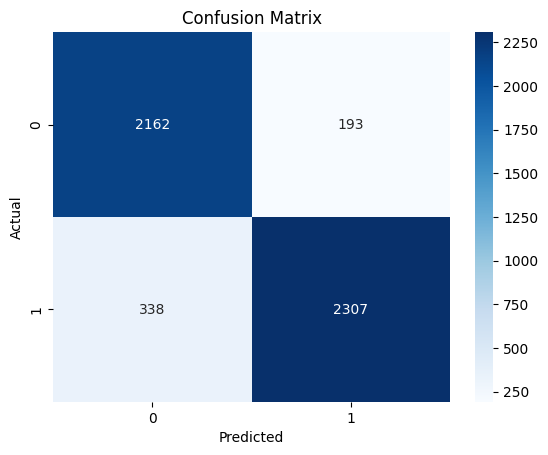

In [22]:
cm = confusion_matrix((probs>=0.5), labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

In [23]:
probs, labels = test_network(model, test_dataloader, device=device)
preds = (probs >= 0.5).int().cpu().numpy()
labels = labels.int().cpu().numpy()
np.set_printoptions(suppress=True)
print(f"model's accuracy score on test set at 50% cuttoff: {accuracy_score((probs>=0.5), labels)*100:0.2f}%")

Evaluating: 100%|██████████| 98/98 [01:39<00:00,  1.02s/it]

model's accuracy score on test set at 50% cuttoff: 89.16%
